In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Capstone1006_FA23/CKA_Analysis_MNIST/
%ls

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1NBUiaEfcN4sFm5VZHTlmo3t5NuD8Qw_W/Capstone1006_FA23/CKA_Analysis_MNIST
 analysis.py                           MNIST_framework_new.py
'CKA Analysis - GPU.ipynb'             MNIST_framework.py
'CKA Analysis.ipynb'                   MNIST.ipynb
 CKA_analysis_pytorch.ipynb           'MNIST Low-Acc Cindy.ipynb'
 CKA_analysis_pytorch_perBatch.ipynb  'MNIST Low-Acc.ipynb'
 CKA_diagonal_Bella.ipynb             'MNIST New_Loss_CKA_manual.ipynb'
 CKA_Heatmap_Net10.png                'MNIST New_Loss_CKA_pytorch.ipynb'
 CKA_Heatmap_Net4.png                 'MNIST New_Loss_CKA_tensorflow.ipynb'
 CKA_loss_Bella.ipynb                 'MNIST New_Loss_CKA_w oPC.ipynb'
 CKA.py                               'MNIST New_Loss + Original_Loss.ipynb'
 CKA_sublayer_Bella.ipynb              MNIST_Training/
 efficient_CKA.py                      __pycache__/
 mnist10_73.pt                         pytorch_CKA_perBatch.py
 mnist_10.pt              

In [2]:
from MNIST_framework_new import *

from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import os
import numpy as np
import pickle
from scipy.spatial.distance import cosine
import random
import math
import time
from google.colab import files

torch.set_default_tensor_type(torch.DoubleTensor)

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


# CKA loss

In [3]:
class CKA_Loss(torch.nn.Module):
    def __init__(self):
        super(CKA_Loss,self).__init__()

    def HSIC(self, K, L, device = "cuda"):
        """
        Computes the unbiased estimate of HSIC metric.
        """
        M = K.shape[0]
        I = torch.eye(M).to(device)
        unit = torch.ones([M, M]).to(device)
        H = I - unit/M
        Khat = H @ K @ H
        Lhat = H @ L @ H
        return torch.abs(torch.sum(Khat * Lhat))+1e-08

    def forward(self, output, device = "cuda", test = False):
        M = len(output)
        hsic_matrix = torch.zeros(M, M)
        for i in range(M):
            X = output[i].flatten(1)
            K = X @ X.t()
            K.fill_diagonal_(0.0)
            hsic_k = self.HSIC(K, K)
            for j in range(i):
                Y = output[j].flatten(1)
                L = Y @ Y.t()
                L.fill_diagonal_(0.0)
                assert K.shape == L.shape, f"Feature shape mismatch! {K.shape}, {L.shape}"
                hsic_matrix[i, j] = self.HSIC(K, L) / torch.sqrt(hsic_k *self.HSIC(L, L))
        # absolute sum of differ
        id = torch.eye(M)
        l = torch.sum(torch.abs(hsic_matrix))
        hsic_visual = hsic_matrix + torch.transpose(hsic_matrix,0,1) +id
        return hsic_visual,l

# Training & Testing Function


In [4]:
def train(model, device, train_loader, optimizer):
    model.train()
    history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data) # output is a length-10 tuple for 10 layers outputs
        optimizer.zero_grad()
        criterion = CKA_Loss()
        _,loss = criterion(output[:10], device)
        #loss = F.nll_loss(output[-1], target, reduction='sum')
        history.append(loss)
        if torch.isnan(loss):
            break
        loss.backward()
        optimizer.step()

    return history

In [5]:
def plotHeatmap(heatmap, index):
    plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest',vmin=0.0,vmax=1.0)
    plt.colorbar(label='Similarity')
    plt.title('CKA')
    plt.xlabel('Layer')
    plt.ylabel('Layer')
    plt.xticks(ticks=np.arange(0, heatmap.shape[0]), labels=index)
    plt.yticks(ticks=np.arange(heatmap.shape[0]-1,-1,-1), labels=index)
    plt.tight_layout()
    plt.show()

In [6]:
def test(model, device, test_loader):
    model.eval()
    nll_loss = 0
    cka_loss = 0
    correct = 0
    m = np.zeros((10,10))
    model.cuda()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            nll_loss += F.nll_loss(output[-1], target, reduction='sum').item()  # sum up batch loss

            criterion = CKA_Loss()
            matrix, loss= criterion(output[:10], device)
            cka_loss += loss.item()
            m += matrix.detach().numpy().reshape((10,10))

            pred = output[-1].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    nll_loss /= len(test_loader)
    cka_loss /= len(test_loader)
    m /= len(test_loader)
    plotHeatmap(m, list(range(10)))
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average NLL loss: {:.4f}, Average CKA loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        nll_loss, cka_loss,  correct, len(test_loader.dataset),  acc))
    return cka_loss,acc

#Training Process

In [7]:
# Training settings
torch.manual_seed(1122)
device = torch.device("cuda")
train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 64}
cuda_kwargs = {'num_workers': 1,'pin_memory': True,'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [8]:
def add_white_noise(img):
    """
    Adds white noise to an image.
    The noise has zero mean and a standard deviation of 0.4
    """
    noise = torch.randn(img.size()) * 0.4
    noisy_img = img + noise
    return noisy_img

transform_ood = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    add_white_noise  # Add your custom transform here
])

dataset1_ood = datasets.MNIST('../data', train=True, download=True, transform=transform_ood)
train_loader_ood = torch.utils.data.DataLoader(dataset1_ood, **train_kwargs)

dataset2_ood = datasets.MNIST('../data', train=False, download=True, transform=transform_ood)
test_loader_ood = torch.utils.data.DataLoader(dataset2_ood, **test_kwargs)

In [9]:
model_init = torch.load('MNIST_Training/mnist10_epoch_2.pt').double()

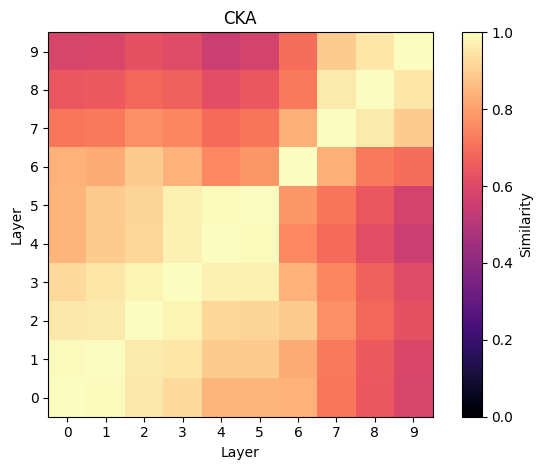


Test set: Average NLL loss: 17.1857, Average CKA loss: 35.7756, Accuracy: 9121/10000 (91%)



In [10]:
_,_ = test(model_init, device, test_loader)

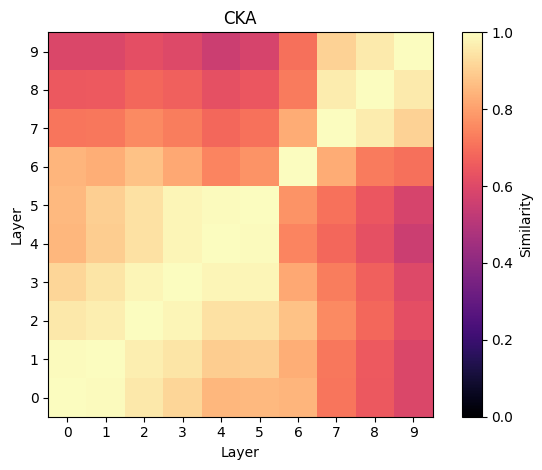


Test set: Average NLL loss: 24.3269, Average CKA loss: 35.8103, Accuracy: 8731/10000 (87%)



In [11]:
_,_ = test(model_init, device, test_loader_ood)

In [ ]:
optimizer = optim.Adadelta(model_init.parameters(), lr=5e-07)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
loss = []
acc = []
history_epoch = []
time_batch = 0
for epoch in range(50):
    start_time = time.time()
    history = train(model_init, device, train_loader, optimizer)
    assert len(history) == len(train_loader), "Nan with batch {}".format(len(history))
    l,a = test(model_init, device, test_loader)
    l_ood,a_ood = test(model_init, device, test_loader_ood)
    loss.append(l)
    acc.append(a)
    #scheduler.step()
    history_epoch.append(history)
    time_batch += time.time()-start_time
print(time_batch/3)

In [ ]:
# # plot for CKA loss term on training process per batch
# ll = history_epoch[0]
# # for i in range(1,len(history_epoch)):
# #   ll = ll+ history_epoch[i]

# plt.figure(figsize = (18,6))
# plt.plot([h.detach().numpy() for h in ll])
# plt.title("CKA loss per batch")